In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


def get_example_dataset(cluster_std=0.80):
    X, y = make_blobs(n_samples=[50, 200], 
                      random_state=0, 
                      cluster_std=cluster_std)
    
    mask_y_sorted = y.argsort()
    
    X, y = X[mask_y_sorted], y[mask_y_sorted]
    return X, y

def pplot(X, y, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plt.show()
    
def plot_target_distribution(y_train, y_test, y):
    get_percentage_ones = lambda x: x.sum() / len(x)
    get_percentage_zeros = lambda x: 1 - get_percentage_ones(x)
    
    bar_width = 0.3
    
    bars1 = [get_percentage_zeros(y_train), get_percentage_ones(y_train)]
    bars2 = [get_percentage_zeros(y_test), get_percentage_ones(y_test)]
    bars3 = [get_percentage_zeros(y), get_percentage_ones(y)]
    
    x1 = [0 + bar_width / 2, bar_width / 2 + bar_width]
    x2 = [x + 1 for x in x1]
    x3 = [x + 2 for x in x1]
    
    plt.bar(x1, bars1, width = bar_width, color = 'blue', edgecolor = 'black', capsize=7, label='train')
    plt.bar(x2, bars2, width = bar_width, color = 'cyan', edgecolor = 'black', capsize=7, label='test')
    plt.bar(x3, bars3, width = bar_width, color = 'green', edgecolor = 'black', capsize=7, label='all')
    
    plt.xticks([x for x in x1 + x2 + x3], ['0', '1'] * 3)
    
    for x, y in zip(x1 + x2 + x3, bars1 + bars2 + bars3):
        plt.text(x = x, y = y + 0.01, s = f'{round(y, 2)}', size = 6)
    
    plt.ylabel('percentage in the sample')
    plt.legend(loc='upper left')
    
    plt.show()

При написании алгоритмов важной частью является его __обобщающая способность__.  
В машинном обучении обобщение обычно относится к способности алгоритма быть эффективным при различных входных данных. Это означает, что модель не сталкивается с ухудшением производительности на новых входных данных из того же распределения обучающих данных.

Далее мы рассмотрим:
- Что такое [кросс-валидация](https://scikit-learn.org/stable/modules/cross_validation.html) (кросс-проверка): определение, цель использования и методы
- Различные варианты CV: hold-out, k-folds, Leave-one-out, Leave-p-out, Stratified k-folds, Repeated k-folds, Nested k-folds, Time Series CV
- Как использовать эти методы в библиотеке sklearn
- Временные ряды

### Что такое кросс-валидация ?

__Кросс-валидация__ - процедура эмпирического оценивания обобщающей способности алгоритмов, обучаемых по прецедентам (объектам, ситуациям).

Алгоритм кросс-валидации:
- Фиксируется некоторое множество разбиений исходной выборки на две подвыборки: обучающую и контрольную.
- Для каждого разбиения выполняется настройка алгоритма по обучающей подвыборке.
- Оценивается средняя ошибка алгоритма на объектах контрольной подвыборки.

Оценкой кросс-валидации называется средняя по всем разбиениям величина ошибки на контрольных подвыборках.

Далее рассмотрим различные вариации кросс-валидации:
- [Hold-out](#Hold-out)
- [k-Fold](#k-Fold)
- [Leave-one-out](#Leave-one-out)
- [Stratified k-Fold](#Stratified-k-Fold)
- [Repeated k-Fold](#Repeated-k-Fold)
- [TimeSeriesSplit](#TimeSeriesSplit)

### Hold-out

Метод hold-out представляет из себя простое разделение на train и test:

<div>
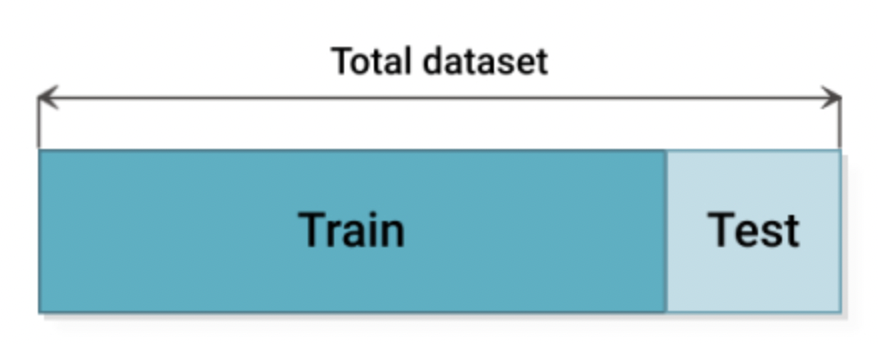
</div>

Обычно мы используем метод hold-out на __больших наборах данных__, поскольку он требует обучения модели только один раз.


Реализация в sklearn:

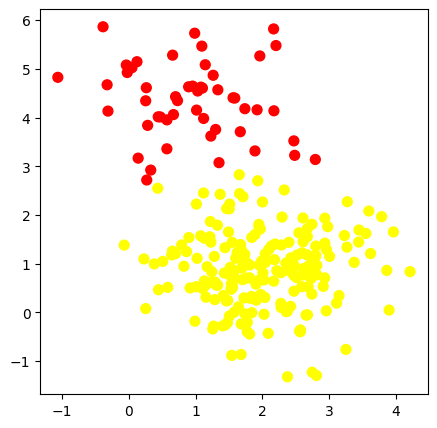

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

X, y = get_example_dataset()
pplot(X, y)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True)

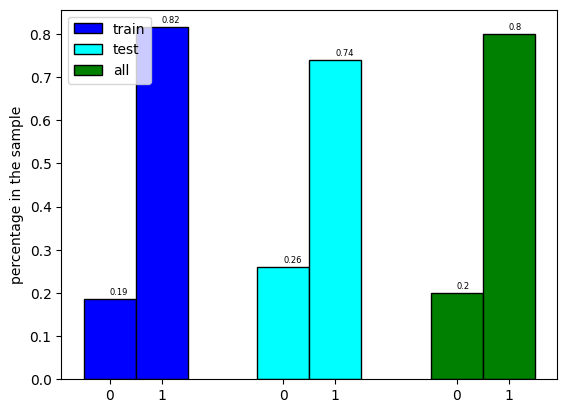

In [4]:
plot_target_distribution(y_train, y_test, y)

У sklearn по дефолту выставлен параметр __shuffle=True__, то есть перед разделением на тренировочное и тестовое множества происходит перемешивание семплов.

При простом случайном разделении на тренировочное и тестовое множества может случиться так, что распределения тренировочного и тестового множеств окажутся не такими, как у всего исходного множества. В качестве примера можно посмотреть на распределение классов в на train и test для предыдущего разделения. Так, на помощь в ситуации c несбалансированными данными может прийти __стратификация__, в train_test_split есть параметр __stratify__.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

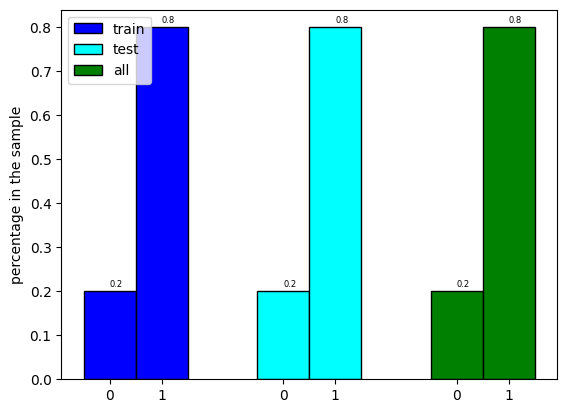

In [6]:
plot_target_distribution(y_train, y_test, y)

__Недостатки__ данного метода:
- Оценка существенно зависит от разбиения, тогда как желательно, чтобы она характеризовала только алгоритм обучения.
- Приходится слишком много объектов оставлять в контрольной подвыборке. Уменьшение длины обучающей подвыборки приводит к смещённой (пессимистически завышенной) оценке вероятности ошибки.

### k-Fold

Метод k-Fold чаще всего имеют в виду, когда говорят о кросс-валидации. Он является обобщением метода hold-out и представляет из себя следующий алгоритм:

Алгоритм техники k-Fold:
- Фиксируется некоторое целое число k (обычно от 5 до 10), меньшее числа семплов в датасете.
- Набор данных разделяется на k равных (если возможно) частей (фолдов).
- Далее происходит k итераций, во время каждой из которых один фолд выступает в роли тестового множества, а объединение остальных — в роли тренировочного. Модель учится на k − 1 фолде и тестируется на оставшемся.
- Финальный скор модели получается либо усреднением k получившихся тестовых результатов

<div>
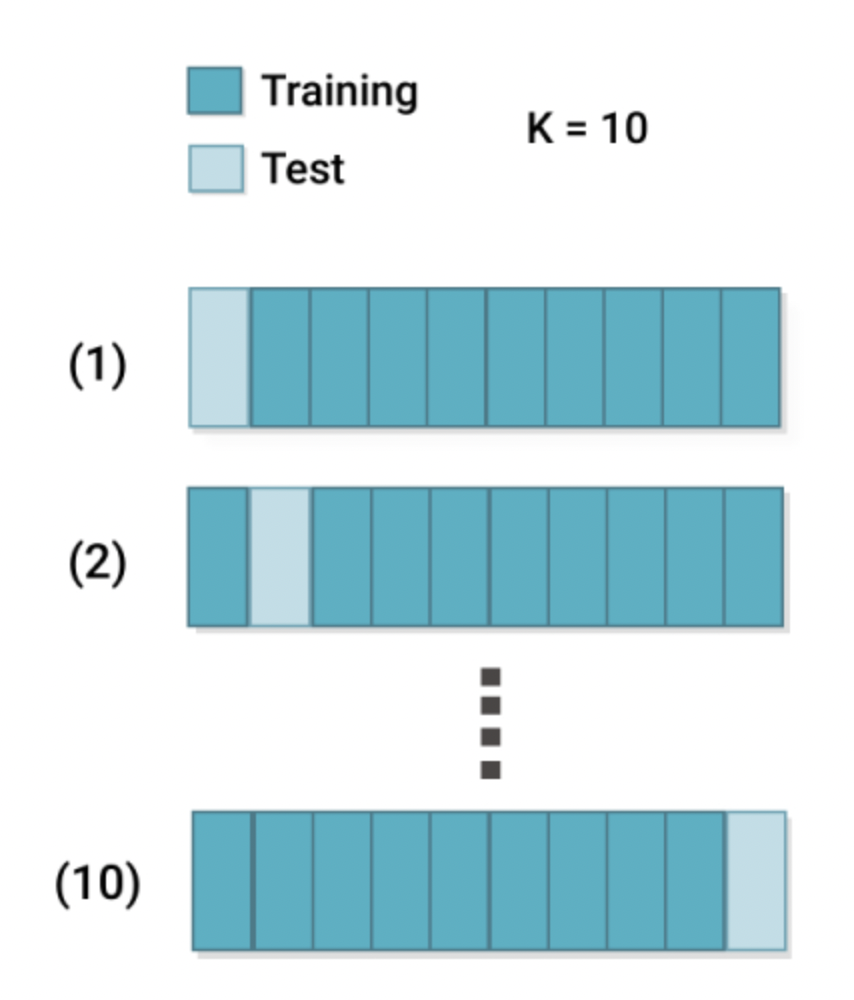
</div>

Для выполнения перекрестной проверки k-Fold будем использовать sklearn.model_selection.KFold.

In [7]:
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


В sklearn есть также метод cross_val_score, принимающий на вход классификатор, данные и способ разбиения данных (либо число фолдов) и возвращающий результаты кросс-валидации:

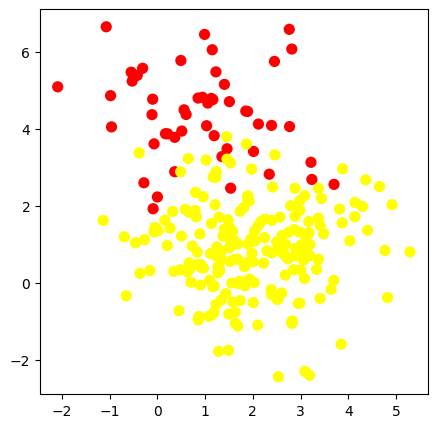

[0.94 0.96 0.92 0.92 0.94]


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

X, y = get_example_dataset(cluster_std=1.2)
pplot(X, y)
 
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
print(scores)

В общем, всегда лучше использовать технику k-Fold вместо Hold-out. При прямом сравнении k-Fold дает более стабильный и достоверный результат, поскольку обучение и тестирование выполняются на нескольких разных частях набора данных.

Тем не менее, метод k-Fold имеет __недостаток__. Увеличение k приводит к обучению большего количества моделей, а процесс обучения может быть очень дорогим и трудоемким.

### Leave-one-out

Метод leave-one-out (LOO) является частным случаем метода k-Fold: в нём каждый фолд состоит ровно из одного семпла.

__Преимущества__ LOO в том, что каждый объект ровно один раз участвует в контроле, а длина обучающих подвыборок лишь на единицу меньше длины полной выборки.

Для LOO sklearn также имеет встроенный метод:

In [9]:
import numpy as np
from sklearn.model_selection import LeaveOneOut

X = np.array([[1, 2], [3, 4]])
y = np.array([1, 2])
loo = LeaveOneOut()

for train_index, test_index in loo.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1] TEST: [0]
TRAIN: [0] TEST: [1]


По сравнению с k-Fold CV, LOO требует построения n моделей вместо k моделей, когда мы знаем, что n, обозначающее количество выборок в наборе данных, намного выше, чем k. Это означает, что __LOO более затратен__ в вычислительном отношении, чем k-Fold, может потребоваться много времени для перекрестной проверки модели с использованием LOOCV.

### Stratified k-Fold

Stratified k-Fold — это метод k-Fold, использующий стратификацию при разбиении на фолды: каждый фолд содержит примерно такое же соотношение классов, как и всё исходное множество. Такой подход может потребоваться в случае, например, очень несбалансированного соотношения классов.

Этот метод также представлен в sklearn:

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=2)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


Все сказанное выше о k-Fold CV справедливо и для стратифицированной методики k-Fold.

### Repeated k-Fold

Repeated k-Fold - это разновидность k-Fold, но в первом случае, k не является количеством кратностей. Это количество раз, которое мы будем обучать модель.

Общая идея заключается в том, что на каждой итерации мы будем случайным образом выбирать образцы по всему набору данных в качестве нашего тестового набора. Например, если мы решим, что 20% набора данных будут нашим тестовым набором, 20% выборок будут выбраны случайным образом, а остальные 80% станут обучающим набором. 

<div>
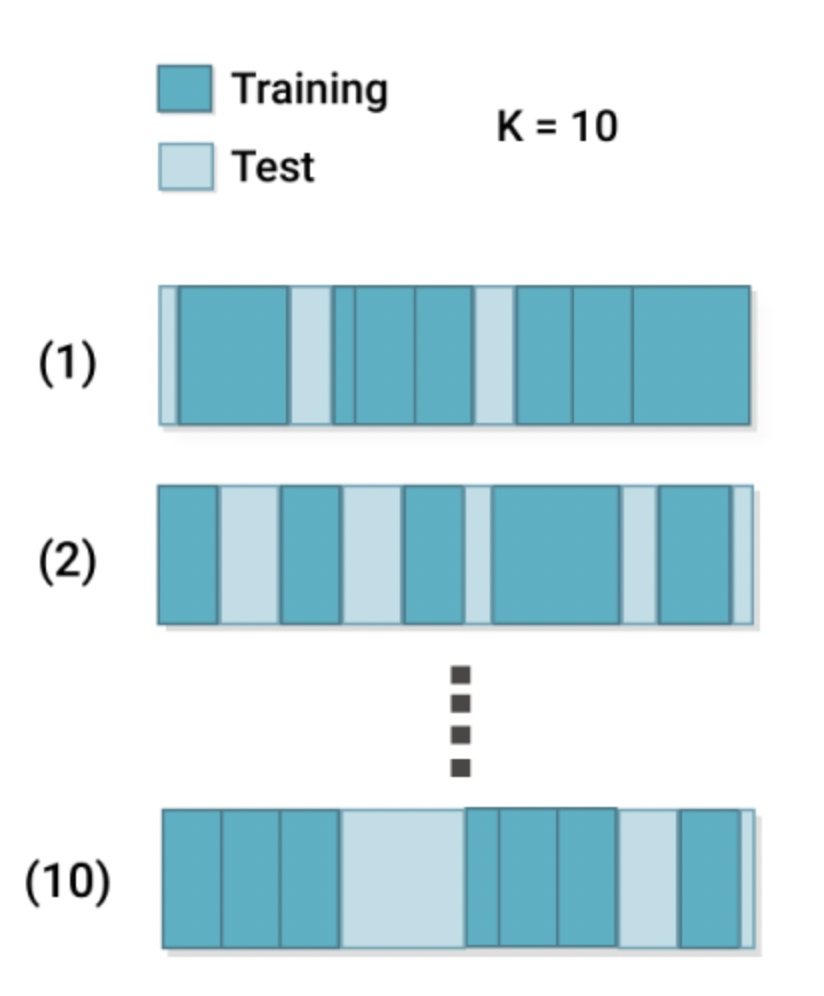
</div>

__Преимущество__ метода заключается в том, что случайный выбор образцов из набора данных делает Repeated k-Fold еще более устойчивым к систематической ошибке отбора.

In [11]:
import numpy as np
from sklearn.model_selection import RepeatedKFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=42)

for train_index, test_index in rkf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0 2] TEST: [1 3]
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]
TRAIN: [1 3] TEST: [0 2]


Тем не менее, есть некоторые недостатки. k-Fold гарантирует, что модель будет проверена на всех образцах, тогда как Repeated k-Fold основан на рандомизации, что означает, что некоторые образцы могут вообще никогда не быть выбраны для включения в тестовый набор. В то же время некоторые образцы могут быть выбраны несколько раз. Таким образом, это плохой выбор для несбалансированных наборов данных.

### TimeSeriesSplit

Традиционные методы перекрестной проверки не работают с последовательными данными, такими как временные ряды, так как события линейно упорядочены по времени. Мы не можем выбирать случайные точки данных и назначать их либо набору test, либо набору train, поскольку нет смысла использовать значения из будущего для прогнозирования ценности в прошлом.

<div>
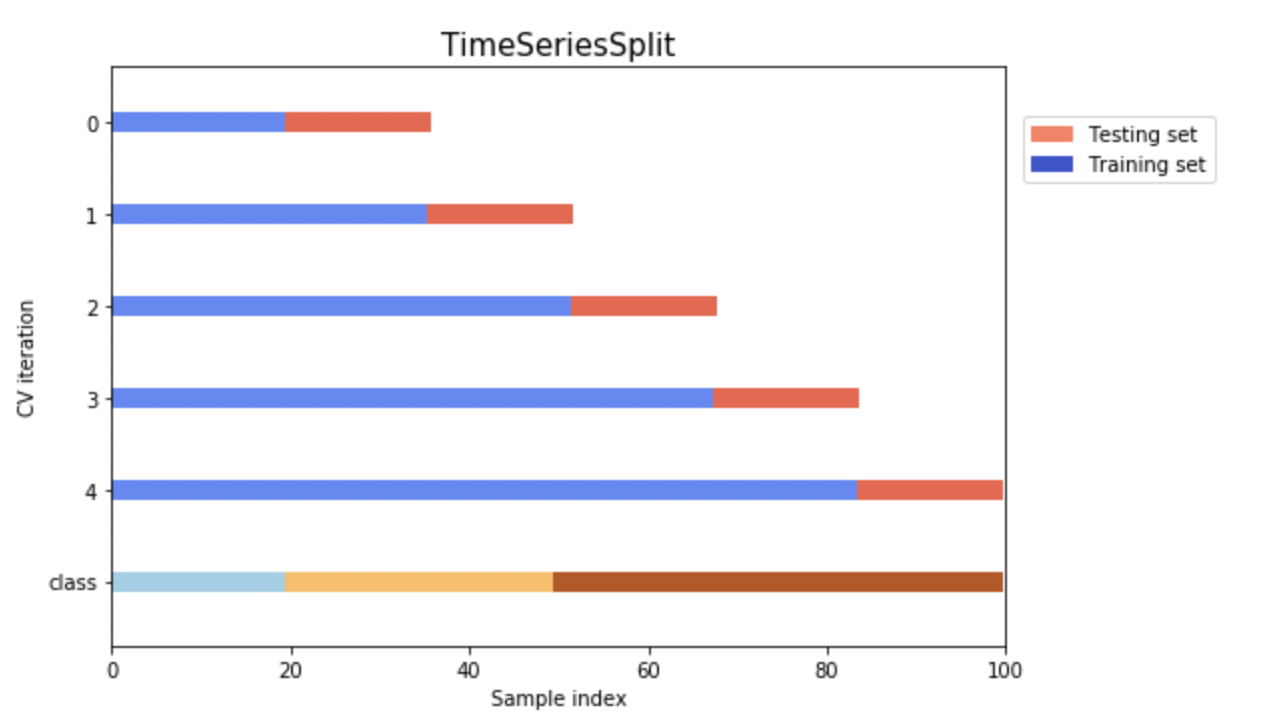
</div>

В sklearn реализована такая схема кросс-валидации:

In [12]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
 
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]
